In [10]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
%env JAX_ENABLE_X64=True

import numpy as np
import time
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import trange
from math import factorial
import cProfile

# set the default device to the cpu
jax.default_device(jax.devices("cpu")[0])
jax.config.update('jax_platform_name', 'cpu')

def clear_gpu_mem():    
    backend = jax.lib.xla_bridge.get_backend()
    for buf in backend.live_buffers(): buf.delete()


N = 10
N_up = 5
N_down = N - N_up


# FACT_UP = 1/np.sqrt(factorial(N_up))
FACT_UP = 1/3
# FACT_DOWN = 1/np.sqrt(factorial(N_down))
FACT_DOWN = 1/3
SYM_DEN = 4
GPU_INDEX = 1

phi_structure = [25,50,50,25]

m = 1
hbar = 1
omega = 1
harmonic_omega = 1

# this just gets the shapes of the weights and biases for a neural network with the given structure
def gen_weight_shapes(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
        w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
        b = np.random.randn(1, sizes[i+1]) 
        weights.append(w)
        biases.append(b) 
    return weights, biases

# get the shapes
weight_shapes, bias_shapes = gen_weight_shapes(N, phi_structure, 1)

# generates a set of weights and biases for a neural network with the given structure
# returns a flattened array of the parameters

def gen_params(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            weights.append(w)
            biases.append(b)
    return flatten_params(weights, biases) 

# calls the neural network with the given parameters and input
@jit
def nn(x, params):
#     params = jax.device_put(params, device=jax.devices("gpu")[GPU_INDEX])
#     x = jax.device_put(x, device=jax.devices("gpu")[GPU_INDEX])
    
    weights, biases = unflatten_params(params) 
    a = x
    for i in range(len(weights) - 1):
        z = jnp.dot(a, weights[i]) + biases[i]
        a = celu(z)
    a = jnp.dot(a, weights[-1]) + biases[-1]
    return a[0][0] 

# takes the weights and biases of a network and returns a flattened array of the parameters
@jit
def flatten_params(weights, biases):
    params = jnp.array([])
    for i in range(len(weights)):
        params = jnp.concatenate((params, weights[i].flatten()))
        params = jnp.concatenate((params, biases[i].flatten()))
    return jnp.array(params)

# takes a flattened array of parameters and returns the weights and biases of the network
@jit
def unflatten_params(params):
    weights = []
    biases = []
    start = 0
    for i in range(len(weight_shapes)):
        end = start + weight_shapes[i].size 
        weights.append(jnp.reshape(jnp.array(params[start:end]), weight_shapes[i].shape))
        start = end
        end = start + bias_shapes[i].size
        biases.append(jnp.reshape(jnp.array(params[start:end]), bias_shapes[i].shape))
        start = end
    return weights, biases



network = gen_params(N, phi_structure, 1)
# the length of the flattened parameters of a single particle neural network
phi_params_length = len(network)

# function that takes the coords, and moves coords[index] to the front of the list
@partial(jit, static_argnums=(1,))
def shift_coords(coords, index):
    return jnp.concatenate([jnp.array([coords[index]]), jnp.array(coords[:index]), jnp.array(coords[index + 1:])])

@partial(jit, static_argnums=(1,))
def inputs_up(coords, j):
    reordered = shift_coords(coords, j)
    sym_piece1 = reordered[1:N_up]
    sym_piece2 = reordered[N_up:]

    new1 = []
    new2 = []
    for i in range(1, N_up):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down+1):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
    
    return jnp.array([reordered[0]] + new1 + new2)

@partial(jit, static_argnums=(1,))
def inputs_down(coords, j):
    reordered = shift_coords(coords, j + N_up)
    
    sym_piece1 = reordered[1:N_up+1]
    sym_piece2 = reordered[N_up + 1:]
    
    new1 = []
    new2 = []
    for i in range(1, N_up+1):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
        
    return jnp.array([reordered[0]] + new1 + new2)

@jit
def Phi_up(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_up, N_up))
    for i in range(N_up):
        ith_params = params[i * phi_params_length : (i + 1) * phi_params_length]
        for j in range(N_up): 
            mat = mat.at[i,j].set(nn(inputs_up(coords, j), ith_params))
    return jnp.linalg.det(mat) * FACT_UP 

@jit
def Phi_down(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_down, N_down))
    for i in range(N_down):
        temp = i + N_up
        ith_params = params[temp * phi_params_length : (temp + 1) * phi_params_length]
        for j in range(N_down): 
            mat = mat.at[i,j].set(nn(inputs_down(coords, j), ith_params))
    return jnp.linalg.det(mat)* FACT_DOWN
@jit
def psi(coords, params):
    return  Phi_up(coords, params) * Phi_down(coords, params) * jnp.exp(-omega * jnp.sum(coords**2))


def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0):
    outputs = []
    num_accepted = 0
    num_total = num_samples * skip_count + thermalization_steps + 1
    rand_coords = np.random.uniform(-variation_size, variation_size, size=(num_total, N))
    rand_accepts = np.random.uniform(0, 1, size=num_total)

#     coords_t = jnp.zeros(N)
    coords_t = np.random.uniform(-1,1,N)
    for step in range(num_total):
        coords_t, accepted = sample_body(params, coords_t, rand_coords[step], rand_accepts[step])
        if accepted:
            num_accepted += 1
        if ((step > thermalization_steps) and (step % skip_count == 0)):
            outputs.append(coords_t)
    return jnp.array(outputs), num_accepted/num_total
@jit
def sample_body(params, coords_t, rand_coords, rand_accepts):
    coords_prime = coords_t + rand_coords
    return jax.lax.cond(rand_accepts < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x,_: (x,True) , lambda _,y: (y,False), coords_prime, coords_t)


psi_hessian = jax.jacfwd(jit(grad(psi, 0)), 0) # type: ignore

@jit
def ddpsi(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(psi_hessian(coords, params))

@jit
def Hpsi(coords, params):
    return jnp.sum((m * .5 * harmonic_omega**2 * coords**2)) - hbar**2 / (2 * m) * jnp.sum(ddpsi(coords, params))/psi(coords, params)

vhpsi = jit(vmap(Hpsi, in_axes=(0, None), out_axes=0)) 

@jit
def grad_helper(coords, params):
    return jnp.sum((m*.5*omega**2*coords**2))*psi(coords, params) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params))

vgrad_helper = jit(vmap(grad_helper, in_axes=(0, None), out_axes=0))

# derivative of the wavefunction with respect to the parameters
dnn_dtheta = jit(grad(psi, 1)) 
vdnn_dtheta = jit(vmap(dnn_dtheta, in_axes=(0, None), out_axes=0))

def grad_comp(s, params, energy_calc):
    return (1/psi(s, params) * dnn_dtheta(s, params)) * (1/psi(s, params)*grad_helper(s, params) - energy_calc) 

vgrad_comp = vmap(grad_comp, in_axes=(0, None, None), out_axes = 0)

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # first sample
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    samples, _= sample(params, num_samples, thermal, skip, variation_size)

#     samples = jax.device_put(samples, device=jax.devices("gpu")[GPU_INDEX])
#     params = jax.device_put(params, device=jax.devices("gpu")[GPU_INDEX])
    
    # compute the energy 
    psiHpsi = vhpsi(samples, params) 
    energy_calc = 1/num_samples * jnp.sum(psiHpsi)
    # compute the uncertainty in the energy
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples) 

    # gradient computation
    grads = vgrad_comp(samples, params, energy_calc)
    gradient_calc = 2/num_samples * jnp.sum(grads, axis=0)
    return gradient_calc, energy_calc, uncert



def step(params_arg, step_num, N, thermal, skip, variation_size):
        gr = gradient(params_arg, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params


env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform
env: JAX_ENABLE_X64=True


In [2]:
# make N sets of parameters
params = gen_params(N, phi_structure, 1)
for i in range(N - 1):
    params = jnp.concatenate((params, gen_params(N, phi_structure, 1)))
print(len(params))

54260


In [3]:
# the jit compilation
start = time.time()
_ = gradient(params, 10**1, 0, 50, .26)
print(time.time() - start)

116.9012222290039


In [4]:
variation = .27
# params = jax.device_put(params, device2jax.devices("gpu")[1])
print("Accept/Reject ratio", sample(params, num_samples=10**2, variation_size=variation)[1])

Accept/Reject ratio 0.21745818111901558


In [5]:
start_params = params
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsa = train(start_params, 10000, 1000, 0 , 1, .27)

Energy = 25.159146355907204: 100%|██████████| 10000/10000 [2:23:01<00:00,  1.17it/s] 


In [6]:
# opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsb = train(resultsa[3], 5000, 4000, 0 , 1, .27)

Energy = 25.095525603601846: 100%|██████████| 5000/5000 [4:41:18<00:00,  3.38s/it]  


In [17]:
# opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsc = train(resultsb[3], 1000, 8000, 0, 1, .28)

Energy = 25.065984109185223: 100%|██████████| 1000/1000 [4:15:00<00:00, 15.30s/it] 


1000 samples, 0, 1

#### Forcing CPU:
jit compilation time:

80 seconds

Training:
~1.11 its/sec

#### Default device placement:
jit compilation time:

81 seconds

Training:
~1.11 its/sec

#### Forcing CPU and "smart" GPU placement
jit compilation time:

40 seconds

Training:
~2.91 its/sec





10000 steps (1k samples)

5000 (4k)

1000 (8k)

In [20]:
print(resultsc)

([Array(25.02442734, dtype=float64), Array(25.02741956, dtype=float64), Array(25.0148226, dtype=float64), Array(24.99991857, dtype=float64), Array(25.02130003, dtype=float64), Array(25.01345669, dtype=float64), Array(25.0113367, dtype=float64), Array(24.99024719, dtype=float64), Array(24.95908415, dtype=float64), Array(25.00776132, dtype=float64), Array(25.00712019, dtype=float64), Array(24.98475826, dtype=float64), Array(25.00894904, dtype=float64), Array(24.99680224, dtype=float64), Array(24.9953837, dtype=float64), Array(25.01520296, dtype=float64), Array(25.0339383, dtype=float64), Array(24.99912976, dtype=float64), Array(25.00191719, dtype=float64), Array(24.99771294, dtype=float64), Array(25.01273902, dtype=float64), Array(25.02615919, dtype=float64), Array(24.94771552, dtype=float64), Array(25.03164717, dtype=float64), Array(25.02971492, dtype=float64), Array(24.9699228, dtype=float64), Array(24.99815368, dtype=float64), Array(25.00618239, dtype=float64), Array(25.01692887, dtyp

In [22]:
total_hists =  resultsa[0] + resultsb[0] + resultsc[0]
print(total_hists)

[Array(73.27893976, dtype=float64), Array(60.84049519, dtype=float64), Array(49.29181662, dtype=float64), Array(52.88445536, dtype=float64), Array(45.51932515, dtype=float64), Array(53.78335818, dtype=float64), Array(45.42141992, dtype=float64), Array(42.93707686, dtype=float64), Array(48.5791617, dtype=float64), Array(53.05162829, dtype=float64), Array(51.13860679, dtype=float64), Array(50.51647949, dtype=float64), Array(44.62545527, dtype=float64), Array(43.990439, dtype=float64), Array(45.76539267, dtype=float64), Array(44.6327336, dtype=float64), Array(64.19488975, dtype=float64), Array(38.37282056, dtype=float64), Array(45.16296829, dtype=float64), Array(42.50219628, dtype=float64), Array(50.31883644, dtype=float64), Array(48.04177936, dtype=float64), Array(50.09732697, dtype=float64), Array(59.00194748, dtype=float64), Array(48.07124309, dtype=float64), Array(45.10289683, dtype=float64), Array(54.34430793, dtype=float64), Array(48.63655329, dtype=float64), Array(60.84234866, dtyp

In [27]:
import pickle

with open('5u5d_resultsa.pickle', 'wb') as handle:
    pickle.dump(resultsa, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('5u5d_resultsb.pickle', 'wb') as handle:
    pickle.dump(resultsb, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('5u5d_resultsc.pickle', 'wb') as handle:
    pickle.dump(resultsc, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# print energy after each training ends


Minimum value:  25.066(19)
Fractional error:  0.00264(74)
25.065984109185223
0.018514472847151305


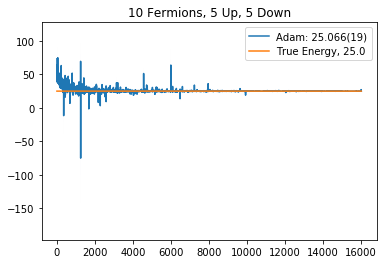

In [24]:
true_energy = 1/2 + 1/2 + 3/2 + 3/2 + 5/2 + 5/2 + 7/2 + 7/2 + 9/2 + 9/2

total_hists =  resultsa[0] + resultsb[0] + resultsc[0]  
# + resultsd[0] 
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1] + resultsb[1] + resultsc[1] 
# + resultsd[1] 
# + resultse[1]
# + resultsd[1]

total_hists = jax.device_put(total_hists, device=jax.devices("cpu")[0])


# get index of minimum value
min_val = np.min(total_hists)
min_val = total_hists[-1]
min_index = total_hists.index(min_val)
min_err = total_uncerts[min_index]
val = gv.gvar(min_val, min_err)
fractional_error = (val - true_energy)/true_energy
print("Minimum value: ", val)
print("Fractional error: ", fractional_error)

plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam: " + str(val))
# plt.xlim(1000, 1050)
# plt.ylim(0, 10)
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (min_val - true_energy)/true_energy*100
# plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title("10 Fermions, 5 Up, 5 Down")
print(min_val)
print(min_err)
plt.show()

In [50]:

params = resultsc[3]
params = start_params
params = jax.device_put(params, device=jax.devices("cpu")[0])
start = time.time()
samples, _= sample(params, 100000, 0, 1, .28)
print(time.time() - start)

52.53346014022827


In [38]:
samples = samples[1000:]

In [39]:
psiHpsi = vhpsi(samples, params)
mean_energy = 1/198000 * jnp.sum(psiHpsi)

In [44]:
print(mean_energy)
print(np.std(psiHpsi)/np.sqrt(198000))

25.00735801990614
0.0010619852627248715


0.0028348468466953165


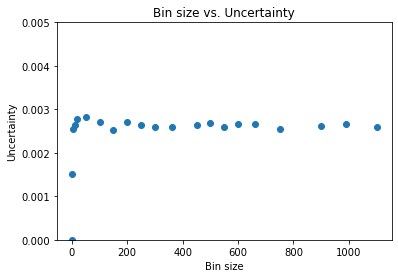

In [47]:
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts

energies = psiHpsi

# bins = np.linspace(1, 100, 100, dtype=int)
bins = [1,2,5,10,20,50,100,150,200,250,300,360,450,500,550,600,660,750,900,990,1100]
# now plot the average energy as a function of the number of bins
us = []
for b_size in bins:
    us.append(bin_samples(energies, b_size))
plt.scatter(bins, us)
plt.title("Bin size vs. Uncertainty")
plt.xlabel("Bin size")
plt.ylim(0,0.005)
plt.ylabel("Uncertainty")
print(max(us))
plt.show()